In [1]:
from __future__ import print_function 
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import WIDERFace_ROOT , WIDERFace_CLASSES as labelmap
from PIL import Image
from data import WIDERFaceDetection, WIDERFaceAnnotationTransform, WIDERFace_CLASSES, WIDERFace_ROOT, BaseTransform , TestBaseTransform
from data import *
import torch.utils.data as data
from face_ssd import build_ssd
#from resnet50_ssd import build_sfd
import pdb
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import time
import copy

import joblib

import torchvision


from utils.infer_utils import *


%load_ext autoreload
%autoreload 2



# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6"

## Load Imagenet 

In [2]:
IMG_Size = 320
imagenet_data = joblib.load('imagenet_data.pkl')

In [3]:
len(imagenet_data)

1281167

## Load All Bounding Boxes

In [3]:
bbox_fnames = os.listdir('./bboxes_imagenet/')
bbox_ind = np.argsort([int(i.split('_')[2]) for i in bbox_fnames])
print(bbox_ind)
sorted_bbox_fnames = [bbox_fnames[i] for i in bbox_ind]




[15 25 26  2 23 10 11 28  3 16 13  0 27 22  8 24  1 18  4  7 12 19  6 17
 20 14  9  5 21]


In [4]:
all_boxes = []
for i in sorted_bbox_fnames:
    all_boxes = all_boxes + joblib.load('./bboxes_imagenet/'+i)

## Load All Shapes

In [5]:
shape_fnames = os.listdir('./shapes_imagenet/')

# print(shape_fnames)

# for i in shape_fnames:
#     print(i.split('_'))

shape_ind = np.argsort([int(i.split('_')[2]) for i in shape_fnames])
print(shape_ind)
sorted_shape_fnames = [shape_fnames[i] for i in shape_ind]



[9 0 4 8 3 5 7 2 1 6]


In [6]:
all_shapes = np.empty((0,2))
for i in sorted_shape_fnames:
    all_shapes = np.append(all_shapes, np.loadtxt('./shapes_imagenet/'+i,delimiter=','), axis=0)
    
# all_shapes_ = np.append(np.repeat(all_shapes, 2, axis=1)/IMG_Size, np.ones((len(all_shapes),1)), axis =1)
all_shapes_ = np.tile(all_shapes[:,::-1], 2)/IMG_Size


In [7]:
all_boxes_ = []
for i in range(len(all_boxes)):
    bbox = np.rint(all_boxes[i][:,:4]*all_shapes_[i]).astype(np.int32).clip(min=0)
    bbox[:,2] = bbox[:,2] - bbox[:,0]
    bbox[:,3] = bbox[:,3] - bbox[:,1]
    all_boxes_.append(bbox)
    

In [8]:
face_nums = []
for i in range(len(all_boxes_)):
    face_nums.append(all_boxes_[i].shape[0])
    
    
face_ind = np.argsort(face_nums)

In [9]:
image_fnames = [i[0].split('train/')[1] for i in imagenet_data.imgs]

In [10]:
image_fnames

['n01440764/n01440764_10026.JPEG',
 'n01440764/n01440764_10027.JPEG',
 'n01440764/n01440764_10029.JPEG',
 'n01440764/n01440764_10040.JPEG',
 'n01440764/n01440764_10042.JPEG',
 'n01440764/n01440764_10043.JPEG',
 'n01440764/n01440764_10048.JPEG',
 'n01440764/n01440764_10066.JPEG',
 'n01440764/n01440764_10074.JPEG',
 'n01440764/n01440764_1009.JPEG',
 'n01440764/n01440764_10095.JPEG',
 'n01440764/n01440764_10108.JPEG',
 'n01440764/n01440764_10110.JPEG',
 'n01440764/n01440764_10120.JPEG',
 'n01440764/n01440764_10124.JPEG',
 'n01440764/n01440764_10150.JPEG',
 'n01440764/n01440764_10159.JPEG',
 'n01440764/n01440764_10162.JPEG',
 'n01440764/n01440764_10183.JPEG',
 'n01440764/n01440764_10194.JPEG',
 'n01440764/n01440764_10211.JPEG',
 'n01440764/n01440764_10218.JPEG',
 'n01440764/n01440764_10227.JPEG',
 'n01440764/n01440764_1024.JPEG',
 'n01440764/n01440764_10251.JPEG',
 'n01440764/n01440764_10254.JPEG',
 'n01440764/n01440764_10281.JPEG',
 'n01440764/n01440764_10290.JPEG',
 'n01440764/n01440764_

In [11]:
with open('imagenet_bbox.txt', 'w') as writer:
    for i in range(len(image_fnames)):
        writer.write(image_fnames[i]+'\n')
        writer.write(str(face_nums[i])+ '\n')
        if face_nums[i] > 0:
            for j in range(len(all_boxes_[i])):
                writer.write(' '.join(map(str, all_boxes_[i][j]))+' 0 0 0 0 0 0\n')
        else:
            writer.write('0 0 0 0 0 0 0 0 0 0\n')
#         if i > 10:
#             break

In [12]:
indices = np.arange(len(image_fnames))
np.random.shuffle(indices)

with open('imagenet_bbox_randomized.txt', 'w') as writer:
    for i in indices:
        writer.write(image_fnames[i]+'\n')
        writer.write(str(face_nums[i])+ '\n')
        if face_nums[i] > 0:
            for j in range(len(all_boxes_[i])):
                writer.write(' '.join(map(str, all_boxes_[i][j]))+' 0 0 0 0 0 0\n')
        else:
            writer.write('0 0 0 0 0 0 0 0 0 0\n')
#         if i > 10:
#             break

In [ ]:
len(indices)

In [ ]:
image_fnames[837238]

In [ ]:
np.where(indices==837238)

In [ ]:
count = 0
for i in indices:
    print(i)
    count +=1
    if count>10:
        break

In [14]:
face_ind

array([ 640583,  813859,  813860, ...,  513502, 1139932,  837238])

In [15]:
print(all_boxes_[840120], all_boxes[840120], all_shapes[840120], all_shapes_[840120], image_fnames[837238])

[[111 162  30  34]
 [183 193  24  29]
 [261 168  24  28]] [[101.45293157 103.87318987 128.61221953 125.35752917   0.98592377]
 [166.97682753 123.27191435 189.02927474 141.85248738   0.98082364]
 [238.08630758 107.68644866 259.96513619 125.64115135   0.97699362]] [500. 351.] [1.096875 1.5625   1.096875 1.5625  ] n03763968/n03763968_2987.JPEG


In [ ]:
i = 840120

bbox = all_boxes[i][:,:4]*all_shapes_[i]
print(bbox)

# bbox = all_boxes[840120]
# bbox
print(bbox[:,2] - bbox[:,0])
print(bbox[:,3] - bbox[:,1])

## Animal Faces 
Animal faces are being detected in the bboxes. Try to find out the reasons for the screw up

In [63]:
WIDERFace_CLASSES = ['face']
trained_model = './weights/WIDERFace_DSFD_RES152.pth'
cuda = True
img_root = './data/worlds-largest-selfie.jpg'
save_folder = 'eval_tools/'
visual_threshold = 0.95
IMG_Size = 320
max_im = 1000
start_idx = 0
num_images = 32768
end_idx = start_idx+num_images
indices = np.arange(start_idx,end_idx)
print(indices)
BATCH_SIZE = 1
NUM_WORKERS = 1
PIN_MEMORY = False


shrink = 1
st = 0.5
bt = 2
max_im_shrink = max_im/IMG_Size

small_box_thresh = 15


means = (104, 117, 123)
means = torch.from_numpy(np.array(means))
means = means.unsqueeze(-1)
means = means.unsqueeze(-1)



cfg = widerface_640
thresh = cfg['conf_thresh']




[    0     1     2 ... 32765 32766 32767]


In [54]:
cuda = torch.cuda.is_available()
torch.multiprocessing.set_start_method("spawn")

if cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [60]:
PIN_MEMORY = False
BATCH_SIZE = 1
NUM_WORKERS = 1

transform_a = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((IMG_Size,IMG_Size)),
    transforms.ToTensor()
    
])

imagenet_dataset_a = copy.copy(imagenet_data)
imagenet_dataset_a.transform = transform_a
# imagenet_data_a = torch.utils.data.Subset(imagenet_dataset_a, indices)
data_loader_a = torch.utils.data.DataLoader(imagenet_dataset_a,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

### Load Network

In [62]:

num_classes = len(WIDERFace_CLASSES) + 1 # +1 background
net = build_ssd('test', cfg['min_dim'], num_classes) # initialize SSD
net.load_state_dict(torch.load(trained_model))

if torch.cuda.device_count() > 1:  
    net = nn.DataParallel(net) #enabling data parallelism

net.cuda()

net.eval()
print('Finished loading model!')

loading pretrained resnet model
Finished loading model!


837238


array([[ 14, 210,  12,  15],
       [  8, 178,  13,  14],
       [340, 208,  13,  16],
       [183, 207,  13,  15],
       [  1, 126,  12,  15],
       [192, 100,  12,  14],
       [158, 104,  13,  14],
       [461, 209,  12,  14],
       [ 74, 240,  13,  15],
       [140, 145,  12,  14],
       [483, 236,  13,  17],
       [160, 239,  14,  15],
       [258, 175,  13,  15],
       [168, 184,  13,  15],
       [ 80, 181,  12,  15],
       [140, 213,  13,  15],
       [300, 144,  14,  15],
       [ 43, 179,  13,  15],
       [441, 127,  11,  13],
       [256, 235,  15,  17],
       [ 20, 151,  12,  13],
       [377, 178,  14,  16],
       [223, 208,  14,  16],
       [ 57, 214,  13,  15],
       [210, 238,  13,  15],
       [378, 209,  13,  15],
       [258, 149,  12,  13],
       [300, 230,  14,  17],
       [478, 180,  12,  15],
       [210, 182,  13,  15],
       [347, 238,  15,  17],
       [185, 126,  13,  14],
       [341, 180,  13,  16],
       [183, 148,  12,  14],
       [260, 2

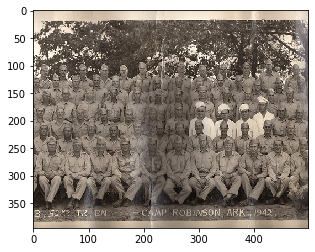

In [16]:
iname = 'n03763968/n03763968_2987.JPEG'
num = np.where([i == iname for i in image_fnames])
print(num[0][0])
plt.imshow(imagenet_data[num[0][0]][0].permute(1,2,0))
all_boxes_[num[0][0]]

In [110]:
transform = TestBaseTransform((104, 117, 123))
thresh=cfg['conf_thresh']
img_id = 'face'

from_memory = False
data_loader = data_loader_a
img_num = num[0][0]

if from_memory:
#     img_root = '../face-detection-project-prakash/img.jpg'
    img_root = './data/worlds-largest-selfie.jpg'
    path = img_root
    img = cv2.imread(path, cv2.IMREAD_COLOR)
else: 
    img = data_loader.dataset[img_num][0].permute(1,2,0).numpy()
    img = img[:,:,::-1]*255



In [111]:
# max_im_shrink = ( (2000.0*2000.0) / (img.shape[0] * img.shape[1])) ** 0.5
shrink = max_im_shrink if max_im_shrink < 1 else 1
x = torch.from_numpy(transform(img)[0]).permute(2, 0, 1)


In [112]:
det0 = infer(net , img , transform , thresh , cuda , shrink)
det1 = infer_flip(net , img , transform , thresh , cuda , shrink)


# shrink detecting and shrink only detect big face
st = 0.5 if max_im_shrink >= 0.75 else 0.5 * max_im_shrink
det_s = infer(net , img , transform , thresh , cuda , st)
index = np.where(np.maximum(det_s[:, 2] - det_s[:, 0] + 1, det_s[:, 3] - det_s[:, 1] + 1) > 30)[0]
det_s = det_s[index, :]


# enlarge one times
factor = 2
bt = min(factor, max_im_shrink) if max_im_shrink > 1 else (st + max_im_shrink) / 2
det_b = infer(net , img , transform , thresh , cuda , bt)


# enlarge small iamge x times for small face
# if max_im_shrink > factor:
#     bt *= factor
#     while bt < max_im_shrink:
#         det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , bt)))
#         bt *= factor
#     det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , max_im_shrink) ))


    
if bt > 1:
    index = np.where(np.minimum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) < 100)[0]
    det_b = det_b[index, :]
else:
    index = np.where(np.maximum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) > 30)[0]
    det_b = det_b[index, :]

    
det = np.row_stack((det0, det1, det_s, det_b))
det = bbox_vote(det)

In [113]:
vis_detections(img.astype(np.int32) , det , 'img_id', 0.5, plot_only=True)

In [114]:
bbox = np.array([-1, -12, 23, 50])
print(bbox)
print(bbox.astype(np.uint32))

[ -1 -12  23  50]
[4294967295 4294967284         23         50]


In [119]:
t1 = 0
t2 = 0
for i in range(1000):
    bbox = np.arange(-100, 100)

    # for i in range(1000):

    start = time.time()
    bbox_2 = bbox.clip(min=0)
    end = time.time()
    t1  += end-start



    start = time.time()
    bbox[bbox<0] = 0
    end = time.time()
    t2  += end-start


print(t1/1000, t2/1000)

3.1507015228271484e-06 5.7795047760009765e-06


In [120]:
print(bbox_2)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99]
